<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit8/Max_BentU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project: Predicting Joe Biden's approval rating

For my Unit 8 project, I will be trying to predict Joe Biden's approval and disapproval ratings using [gas prices](https://www.eia.gov/dnav/pet/hist/leafhandler.ashx?n=pet&s=emm_epmr_pte_nus_dpg&f=m), [egg prices](https://fred.stlouisfed.org/series/APU0000708111), [the inflation rate](https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL) (as calculated by the sticky CPI), [the unemployment rate](https://fred.stlouisfed.org/series/UNRATE) and [the amount of fentanyl seized at the southern border](https://www.cbp.gov/document/stats/nationwide-drug-seizures). The most loyal of you project-readers will be wondering "Whoa! What happened to baseball?" and to that I refute the notion that baseball was ever gone to begin with.

On the Orioles' opening day in 2009, [he completely botched the ceremonial first pitch](https://www.mlb.com/video/vp-joe-biden-s-first-pitch), throwing it above the heads of both the catcher and mascot. In so doing, he became a part of the sport of baseball, intertwining himself inside the deep connection between baseball and our nation's post-Civil War history.

Why those variables? During Biden's presidency, conservatives used most of these statistics (save for unemployment rate) to try and disparage the administration. Gas and egg prices were large focal points for Republican criticism during the presidency, with gas prices spiking in 2022 due to post-COVID increases in demand and the Russian invasion of Ukraine and egg prices spiking due to bird flu outbreaks. Conservatives also pointed to greater inflation and an increased amount of fentanyl seizures as reasons as to why the Biden administration should be ousted. As the sticky CPI excludes food and energy, I'm including gas and egg prices separately. I've also included the unemployment rate, which can be helpful information when combined with the inflation rate.

## Data wrangling

Unfortunately for me, every single dataset in this project has a different way of storing things. Let's fix that.

In [ ]:
# import datasets
egg_prices = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/egg_prices.csv')
gas_prices = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/U.S._Regular_All_Formulations_Retail_Gasoline_Prices.csv')
inflation_rate = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/inflation_rate.csv')
unemployment_rate = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/UNRATE.csv')
drugs_1 = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/nationwide-drugs-fy21-fy24.csv')
drugs_2 = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/nationwide-drugs-fy22-fy25-jan(1).csv')
approval_ratings = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/favorability_polls.csv')

In [ ]:
egg_prices.rename(columns={'APU0000708111': 'dozen_price'}, inplace=True)
gas_prices.rename(columns={'U.S. Regular All Formulations Retail Gasoline Prices Dollars per Gallon': 'gas_price'}, inplace=True)
inflation_rate.rename(columns={'CORESTICKM159SFRBATL': 'inflation_rate'}, inplace=True)
unemployment_rate.rename(columns={'UNRATE': 'unemployment_rate'}, inplace=True)

### Drugs

In [ ]:
drugs_1['Drug Type'] = drugs_1['Drug Type'].astype(str)

In [ ]:
drugs_1.query("`Drug Type` == 'Fentanyl' & FY == 2021", inplace=True)

In [ ]:
drugs_1

,FY,Month (abbv),Component,Region,Land Filter,Area of Responsibility,Drug Type,Count of Event,Sum Qty (lbs)
2492,2021,APR,Office of Field Operations,Coastal/Interior,Other,CHICAGO FIELD OFFICE,Fentanyl,6,2.817243
2502,2021,APR,Office of Field Operations,Coastal/Interior,Other,HOUSTON FIELD OFFICE,Fentanyl,2,0.200841
2523,2021,APR,Office of Field Operations,Coastal/Interior,Other,NEW ORLEANS FIELD OFFICE,Fentanyl,3,4.631581
2567,2021,APR,Office of Field Operations,Northern Border,Land Only,DETROIT FIELD OFFICE,Fentanyl,1,0.006658
2592,2021,APR,Office of Field Operations,Southwest Border,Land Only,EL PASO FIELD OFFICE,Fentanyl,4,21.608388
...,...,...,...,...,...,...,...,...,...
4978,2021,SEP,U.S. Border Patrol,Southwest Border,Land Only,BIG BEND SECTOR,Fentanyl,1,0.057300
4986,2021,SEP,U.S. Border Patrol,Southwest Border,Land Only,EL CENTRO SECTOR,Fentanyl,3,2.514500
4993,2021,SEP,U.S. Border Patrol,Southwest Border,Land Only,EL PASO SECTOR,Fentanyl,4,14.655800
5008,2021,SEP,U.S. Border Patrol,Southwest Border,Land Only,SAN DIEGO SECTOR,Fentanyl,8,32.735800


In [ ]:
drugs_1['FY'] = drugs_1['FY'].astype(str) + drugs_1['Month (abbv)'].astype(str)

In [ ]:
drugs_1.drop(columns=['Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility', 'Count of Event'], inplace=True)

KeyError: "['Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility', 'Count of Event'] not found in axis"

In [ ]:
drugs_1.drop(columns=['Drug Type'], inplace=True)

In [ ]:
drugs_1 = drugs_1.groupby('FY').sum()

In [ ]:
drugs_1['month'] = drugs_1.index

In [ ]:
for value in drugs_1['month']:
  drugs_1['month'] = pd.to_datetime(drugs_1['month'], format='%Y%b')

2021 drugs wrangled.

In [ ]:
drugs_2['FY'] = drugs_2['FY'].astype(str) + drugs_2['Month (abbv)'].astype(str)

In [ ]:
drugs_2

,FY,Month (abbv),Component,Region,Land Filter,Area of Responsibility,Drug Type,Count of Event,Sum Qty (lbs)
0,2025 (FYTD)DEC,DEC,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Ecstasy,1,0.825190
1,2025 (FYTD)DEC,DEC,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Marijuana,5,3.457289
2,2025 (FYTD)DEC,DEC,Office of Field Operations,Coastal/Interior,Other,ATLANTA FIELD OFFICE,Other Drugs**,5,21.730745
3,2025 (FYTD)DEC,DEC,Office of Field Operations,Coastal/Interior,Other,BALTIMORE FIELD OFFICE,Cocaine,3,0.776600
4,2025 (FYTD)DEC,DEC,Office of Field Operations,Coastal/Interior,Other,BALTIMORE FIELD OFFICE,Fentanyl,4,7.476625
...,...,...,...,...,...,...,...,...,...
8146,2023SEP,SEP,U.S. Border Patrol,Southwest Border,Land Only,TUCSON SECTOR,Other Drugs**,4,0.222700
8147,2023SEP,SEP,U.S. Border Patrol,Southwest Border,Land Only,YUMA SECTOR,Fentanyl,2,4.952400
8148,2023SEP,SEP,U.S. Border Patrol,Southwest Border,Land Only,YUMA SECTOR,Marijuana,11,0.412100
8149,2023SEP,SEP,U.S. Border Patrol,Southwest Border,Land Only,YUMA SECTOR,Methamphetamine,2,84.452600


In [ ]:
drugs_2['FY'] = drugs_2['FY'].str.replace(' (FYTD)', '')

In [ ]:
drugs_2.drop(columns=['Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility', 'Count of Event'], inplace=True)

In [ ]:
drugs_2['Drug Type'] = drugs_2['Drug Type'].astype(str)

In [ ]:
drugs_2.query("`Drug Type` == 'Fentanyl'", inplace=True)

In [ ]:
drugs_2 = drugs_2.groupby('FY').sum()
drugs_2['month'] = drugs_2.index

In [ ]:
drugs_2.drop(columns=['Drug Type'], inplace=True)

In [ ]:
drugs_2.drop(columns=['month'], inplace=True)

In [ ]:
drugs_1.drop(columns=['month'], inplace=True)

In [ ]:
drugs_2

,Sum Qty (lbs)
FY,
2022-01-01,862.487813
2022-02-01,680.178563
2022-03-01,1051.569004
2022-04-01,1292.439959
2022-05-01,1080.172676
2022-06-01,700.126424
2022-07-01,2159.849703
2022-08-01,2301.461531
2022-09-01,1855.836049


In [ ]:
drugs_1 = drugs_1.groupby('month').sum()

In [ ]:
drugs_2.drop(['2025-10-01', '2025-11-01', '2025-12-01'], inplace=True)

In [ ]:
fent = pd.concat([drugs_1, drugs_2])

In [ ]:
fent.index.name = 'month'

In [ ]:
fent

,Sum Qty (lbs)
month,
2021-01-01,945.066404
2021-02-01,796.762695
2021-03-01,651.891995
2021-04-01,886.411292
2021-05-01,949.615541
2021-06-01,1056.409906
2021-07-01,837.274322
2021-08-01,1132.538626
2021-09-01,737.273204


### more predictor wrangling

In [ ]:
gas_prices

,Month,gas_price
0,2025-03-01,3.096
1,2025-02-01,3.121
2,2025-01-01,3.076
3,2024-12-01,3.018
4,2024-11-01,3.053
...,...,...
410,1991-01-01,NaN
411,1990-12-01,NaN
412,1990-11-01,1.324
413,1990-10-01,1.335


In [ ]:
gas_prices['Month'] = gas_prices['Month'].str.replace('-', '')

In [ ]:
for value in gas_prices['Month']:
  gas_prices['Month'] = pd.to_datetime(gas_prices['Month'], format='%b%y')

In [ ]:
gas_prices.drop([0,1], inplace=True)

In [ ]:
drop = [x for x in range(51,len(gas_prices))] # shoutout list comprehension

In [ ]:
gas_prices.drop(drop, inplace=True)

In [ ]:
gas_prices.drop([413, 414], inplace=True) # stragglers

In [ ]:
gas_prices = gas_prices.groupby('Month').sum()

,gas_price
Month,
2021-01-01,2.334
2021-02-01,2.501
2021-03-01,2.810
2021-04-01,2.858
2021-05-01,2.985
2021-06-01,3.064
2021-07-01,3.136
2021-08-01,3.158
2021-09-01,3.175


In [ ]:
inflation_rate.rename(columns={'observation_date': 'month'}, inplace=True) # renaming columns for join purposes
unemployment_rate.rename(columns={'observation_date': 'month'}, inplace=True)
egg_prices.rename(columns={'observation_date': 'month'}, inplace=True)

In [ ]:
inflation_rate.drop([x for x in range(0,11)], inplace=True) # remove pre Biden-era stats
unemployment_rate.drop([x for x in range(0,11)], inplace=True)
egg_prices.drop([x for x in range(0,11)], inplace=True)

In [ ]:
inflation_rate.drop([60], inplace=True) # no more trump-era stats
unemployment_rate.drop([60], inplace=True)
egg_prices.drop([60], inplace=True)

In [ ]:
inflation_rate = inflation_rate.groupby('month').sum()
gas_prices = gas_prices.groupby('Month').sum()
unemployment_rate = unemployment_rate.groupby('month').sum()
egg_prices = egg_prices.groupby('month').sum()

In [ ]:
inflation_rate.index = pd.to_datetime(inflation_rate.index)
unemployment_rate.index = pd.to_datetime(unemployment_rate.index)
egg_prices.index = pd.to_datetime(egg_prices.index)

In [ ]:
predictors = pd.concat([gas_prices, egg_prices, inflation_rate, unemployment_rate, fent], axis=1)

In [ ]:
predictors = predictors.rename(columns={"Sum Qty (lbs)": "fent_lbs"})

### predicted wrangling

In [ ]:
drop_cols = ['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id', 'pollster_rating_name',
             'numeric_grade', 'pollscore', 'methodology', 'transparency_score', 'state', 'sponsor_candidate_id', 'sponsor_candidate',
             'sponsor_candidate_party', 'question_id', 'sample_size', 'population', 'subpopulation', 'population_full', 'tracking',
             'notes', 'url', 'url_article', 'url_topline', 'url_crosstab', 'source', 'internal', 'partisan', 'imputed_sample_size',
             'politician_id', 'alternate_answers', 'very_favorable', 'somewhat_favorable', 'somewhat_unfavorable', 'very_unfavorable',
             'end_date', 'created_at']
approval_ratings.drop(columns=drop_cols, inplace=True) # drop columns we don't care about

In [ ]:
approval_ratings.start_date = pd.to_datetime(approval_ratings.start_date)
approval_ratings['politician'] = approval_ratings['politician'].astype(str)

<ipython-input-305-1140638748fa>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  approval_ratings.start_date = pd.to_datetime(approval_ratings.start_date)


In [ ]:
approval_ratings.query("politician == 'Joe Biden'", inplace=True)

In [ ]:
approval_ratings.drop(columns=['politician'], inplace=True)

In [ ]:
approval_ratings.rename(columns={'start_date': 'month'}, inplace=True)

In [ ]:
approval_ratings = approval_ratings.groupby('month')

In [ ]:
approval_ratings

,month,favorable,unfavorable
4,2025-01-12,39.0,58.0
5,2025-01-12,42.0,56.0
11,2025-01-10,40.0,59.0
15,2025-01-09,33.0,58.0
17,2025-01-09,35.0,59.0
...,...,...,...
4600,2020-11-13,59.0,41.0
4603,2020-11-13,55.0,41.0
4606,2020-11-12,44.0,43.0
4611,2020-11-04,48.0,49.0


In [ ]:
approval_ratings = approval_ratings.resample(rule='MS', on='month').mean()

In [ ]:
full_data = pd.concat([predictors, approval_ratings], axis=1)

In [ ]:
full_data.dropna(inplace=True)

In [ ]:
full_data.to_csv('full_data.csv')

## Setup

In [1]:
!pip install pymc-bart
import pymc_bart as pmb

In [19]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_full = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/unit8_data_final.csv')

In [ ]:
data_full

,Unnamed: 0,gas_price,dozen_price,inflation_rate,unemployment_rate,fent_lbs,favorable,unfavorable
0,2021-01-01,2.334,1.466,1.391588,6.4,945.066404,53.488889,41.066667
1,2021-02-01,2.501,1.597,1.403014,6.2,796.762695,54.370370,40.629630
2,2021-03-01,2.810,1.625,1.592602,6.1,651.891995,54.718750,40.187500
3,2021-04-01,2.858,1.620,2.212664,6.1,886.411292,54.069444,40.583333
4,2021-05-01,2.985,1.625,2.569395,5.8,949.615541,52.861111,41.777778
5,2021-06-01,3.064,1.642,2.564809,5.9,1056.409906,52.666897,43.093103
6,2021-07-01,3.136,1.642,2.330438,5.4,837.274322,51.393333,44.290000
7,2021-08-01,3.158,1.709,2.335721,5.1,1132.538626,50.083333,45.536111
8,2021-09-01,3.175,1.835,2.607496,4.7,737.273204,48.142857,47.657143
9,2021-10-01,3.291,1.821,3.009235,4.5,1211.520901,45.974359,49.512821


Here's a Seaborn "pair plot" of all of the data points mapped against each other. Pay close attention to the bottom row: this is how every other data point maps to Biden's approval rating.

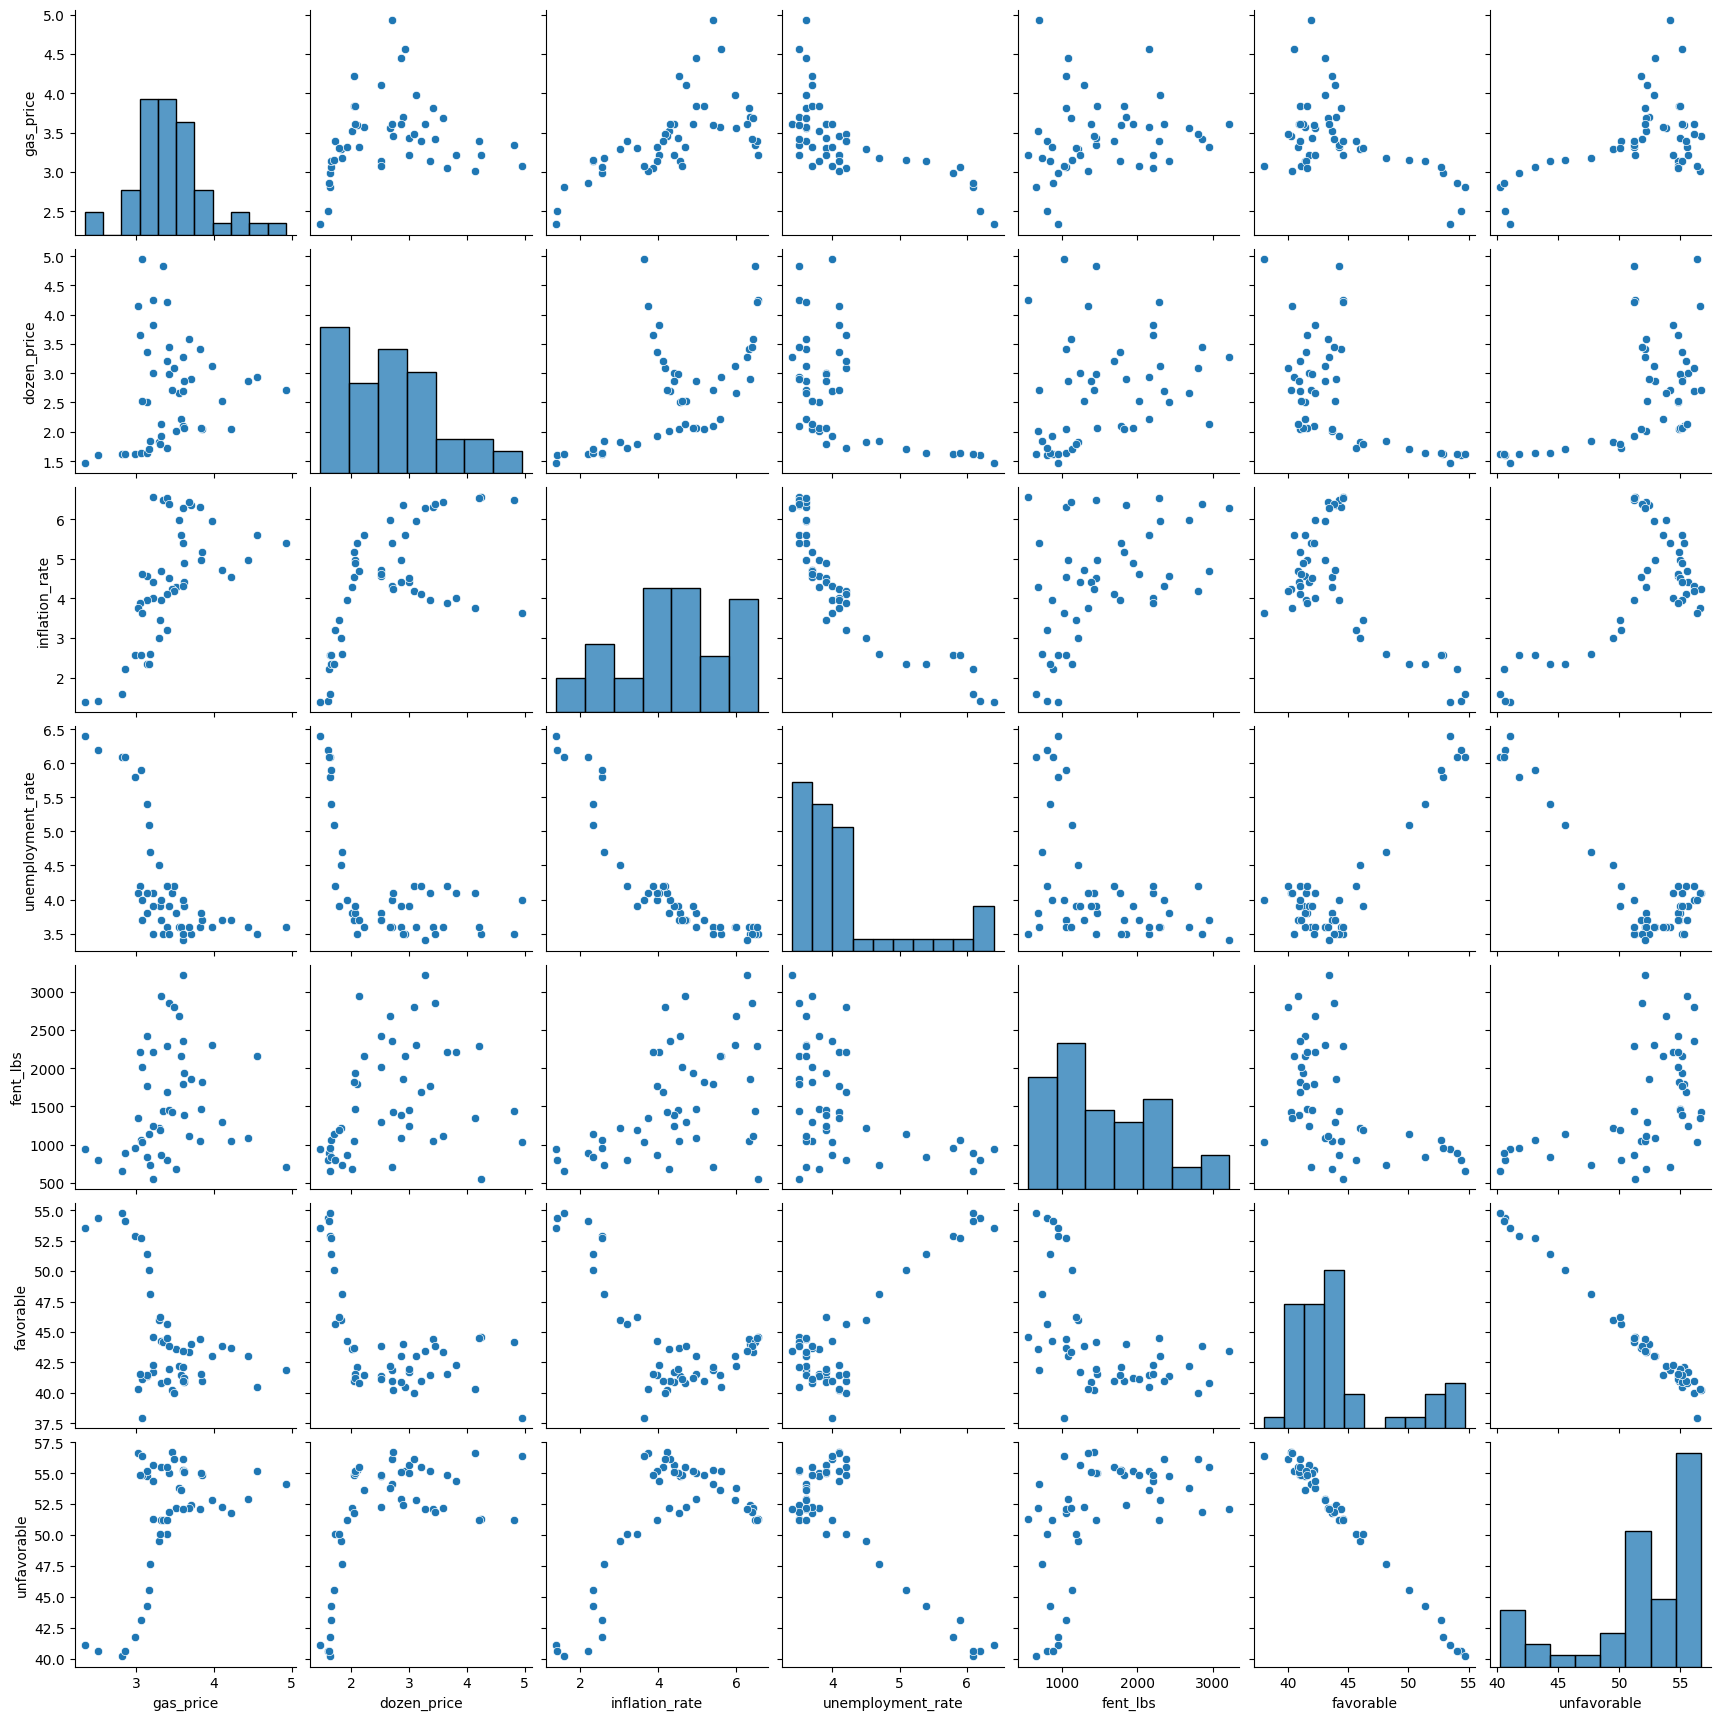

In [20]:
sns.pairplot(data_full)

Here's my causal diagram (too lazy to draw it on paper):

In [ ]:
import graphviz

In [ ]:
dot = graphviz.Digraph(comment='DAG')

dot.node('G', 'gas_prices')
dot.node('E', 'egg_prices')
dot.node('I', 'inflation_rate')
dot.node('U', 'unemployment_rate')
dot.node('F', 'fent_seizures')
dot.node('A', 'unfavorable')

dot.edges(['GA', 'EA', 'IA', 'UA', 'IU', 'UI', 'FA'])

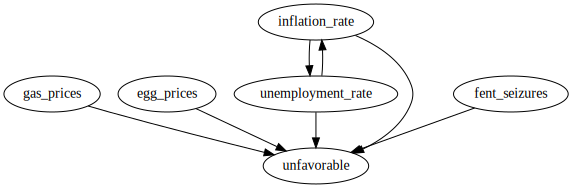

In [ ]:
dot

There's a bit to explain here.

*   A couple of years ago I saw [some analysis](https://www.nytimes.com/2022/09/26/upshot/gas-prices-midterms.html) from Nate Cohn of the NYT that pointed to gas prices being connected with Biden's approval rating; given the car-centric status quo of most of the US, an increase in gas prices could signal an increase in the overall cost of living.
*   Eggs are some of the most common items bought as groceries (it's the most-weighted portion of the ["food at home" section of the CPI](https://www.bls.gov/news.release/cpi.t01.htm)), and so an increase in their price could show dissatisfaction with the President's handling of the economy.
*   The inflation statistic I'm using, sticky CPI, does not include food or energy in their calculation due to their instability, so I've decided to assume no connection between gas prices, egg prices and the inflation rate. Higher inflation could lead to constituent dissatisfaction with the president's handling of the economy, as people do not like an increase in the price level.
*   Unemployment rate should have a positive relationship with presidential disapproval, as people likely think poorly of the economy (and therefore the President) when they don't have jobs.
  *   Additional note: The inflation rate and unemployment rates are usually inverses of one another, as more people having jobs (lower unemployment) causes them to spend more (more money circulated in the economy), causing higher inflation; less people having jobs (higher unemployment) causes them to spend less (less money circulated in the economy), causing lower inflation. If you want a more in-depth explanation, google "keynesian economics". As far as I know, there wasn't any stagflation (high unemployment + inflation) during the Biden admin, so that shouldn't complicate anything.
*   I think the amount of fentanyl seized should have the smallest effect on Biden's approval rating, as the people most likely to care about this were more likely to disapprove of Biden anyways, as well as the fact that drug addiction affects a smaller amount of the population than inflation. I do think it still has an impact, though--overdoses from synthetic opioids like fentanyl are [the leading cause of death amongst 18-45 year olds in the US](https://www.cdc.gov/media/releases/2025/2025-cdc-reports-decline-in-us-drug-overdose-deaths.html), so an increase in access to opioids is still going to negatively affect a lot of people and sour some people on the President's handling of the issue.

Note that "inflation rate" being above unemployment rate is just a consequence of graphviz.

# Model 1

For my first model, I'm going to incorporate all of the variables and see how well it performs; if my DAG is correct, this should work well.

As for my distribution selection, I'm using a BART (woah) with a weak HalfNormal prior and a Normal likelihood. While the percentage of voters who disapprove of the President cannot go negative, implying that we should use a distribution that only uses positive values, the range of disapproval values is relatively low, staying around 40-55, so the likelihood of the model spitting out negative values should be low. I think the distribution

In [ ]:
X = data_full[['gas_price', 'dozen_price', 'inflation_rate', 'unemployment_rate', 'fent_lbs']]
Y = data_full['unfavorable'].to_numpy()

In [ ]:
with pm.Model() as unfav_all:
  s = pm.HalfNormal('s', 1000)
  μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
  μ = pm.Deterministic("μ",pm.math.exp(μ_))
  y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
  idata_unfav_all = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

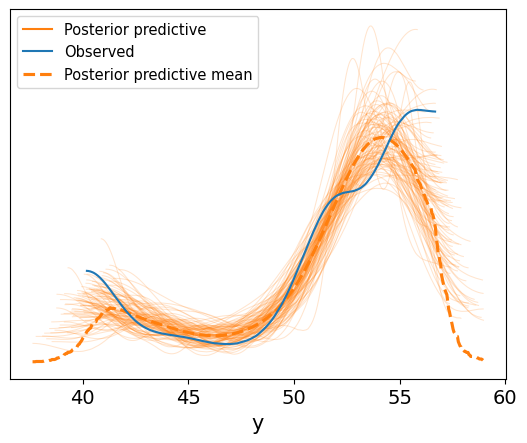

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_unfav_all, unfav_all, extend_inferencedata=True)
az.plot_ppc(idata_unfav_all, num_pp_samples=100, colors=["C1", "C0", "C1"])

Outside of the edges (which is to be expected, as this is a Normal likelihood), this is a pretty good fit! The model struggles a bit around the mode, which is obviously bad, but it gets the general idea right (lower ratings have lower density, higher ratings have higher density).

I'm going to try and see which individual variable maps the best to the posterior predictive, with the best eye-test correlation being below:

In [ ]:
X = X.to_numpy() # allow for the following code to run

In [ ]:
posterior_mean = idata_unfav_all.posterior["μ"]

μ_hdi = az.hdi(ary=idata_unfav_all, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_unfav_all, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


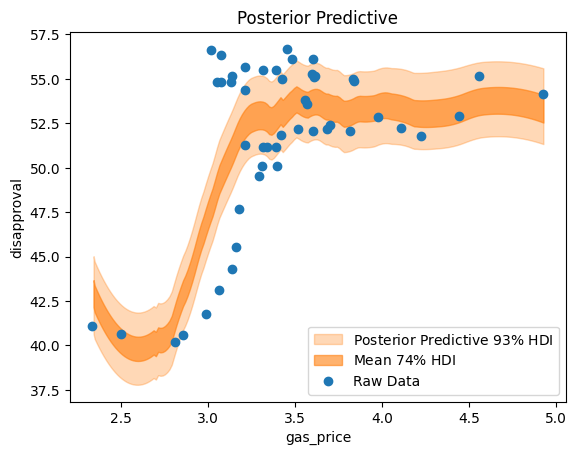

In [ ]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(data_full["gas_price"], data_full["unfavorable"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="gas_price",
    ylabel="disapproval",
);

When I first saw this chart, my jaw dropped. While the posterior predictive doesn't line up exactly with the price of gas, the overall trend is exactly the same: as soon as the price of gas reaches a certain point, the disapproval rating shoots up.

Let's see the pdp/ICE plots:

In [ ]:
X = data_full[['gas_price', 'dozen_price', 'inflation_rate', 'unemployment_rate', 'fent_lbs']] # get the variable names back

array([<Axes: xlabel='gas_price'>, <Axes: xlabel='dozen_price'>,
       <Axes: xlabel='inflation_rate'>,
       <Axes: xlabel='unemployment_rate'>, <Axes: xlabel='fent_lbs'>],
      dtype=object)

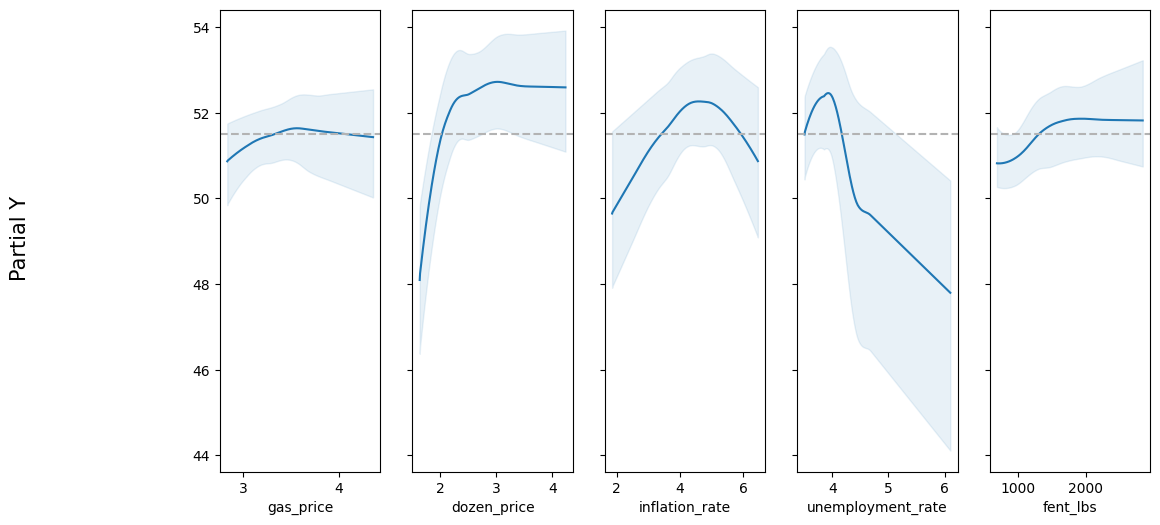

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='gas_price'>, <Axes: xlabel='dozen_price'>,
       <Axes: xlabel='inflation_rate'>,
       <Axes: xlabel='unemployment_rate'>, <Axes: xlabel='fent_lbs'>],
      dtype=object)

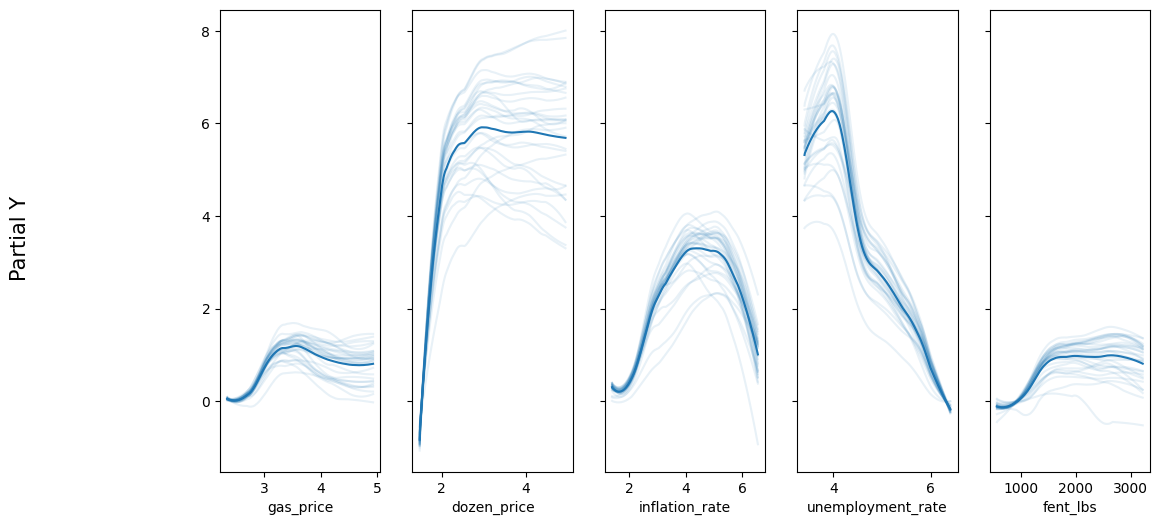

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

These are some weird ICE plots!

According to the model, the variable with the greatest impact on Biden's disapproval rating is the unemployment rate, with it having an inverse relationship with the disapproval rating. This seems incredibly confusing at first--why would people love high unemployment? However, there's a *lot* of variation in the lower unemployment values of the model, which indicates unreliability. This variation could be due to low unemployment being coupled with periods of both low and high inflation, indicating that the nation's consciousness about the "health" of the economy during Biden's presidency is more related to inflation than unemployment. As the unemployment rate rises, the disapproval rate drops, which also doesn't make sense, unless you consider the fact that Biden's first several months (and his approval "honeymoon effect") corresponded with the nation's recovery from the pandemic, when unemployment was high. This indicates that the model's interpretation of the trend in the unemployment rate unemployment rate is less about the unemployment rate itself, and instead about other effects that the unemployment rate happens to correspond with, like time or inflation. Tl;dr, I don't think the unemployment rate means anything wrt presidential approval, everything can be explained by other factors.

<Axes: xlabel='Unnamed: 0', ylabel='unfavorable'>

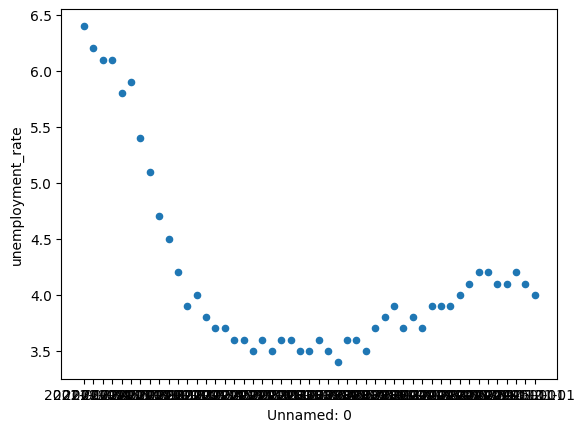

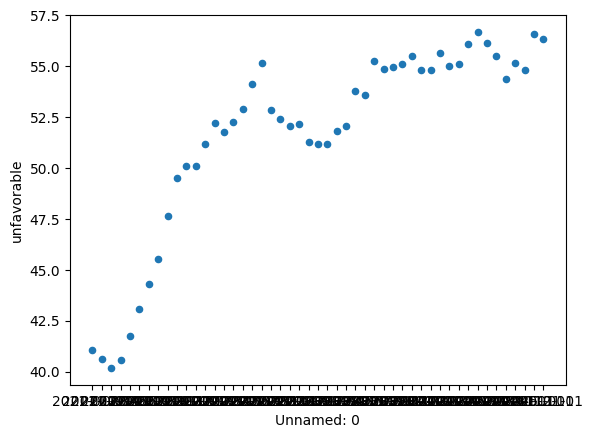

In [15]:
data_full.plot.scatter(x='Unnamed: 0', y='unemployment_rate') # unemployment v. time
data_full.plot.scatter(x='Unnamed: 0', y='unfavorable') # disapproval v. time

The next highest correlation seems to be with egg prices, which show a very consistent spike at low values before diverging into what looks like noise at around $2/dozen. Public opinion being subject to lots of change at low egg prices makes sense, as eggs are an important inelastic good. The noise is probably due to the difference between the large spike in egg prices coming in 2022 (during a general period of high inflation) and another spike during 2024 as bird flu decreased the supply of chickens; the first big spike coincided with an increase in Biden's disapproval rating, whereas the second big spike did not. Overall, I think the trend the model found between egg prices and Biden's disapproval rating makes sense, especially given that the nation seemed to respond to inflation more than it did unemployment (as I explained earlier) although it probably overstates the relationship a little bit.

<Axes: xlabel='Unnamed: 0', ylabel='unfavorable'>

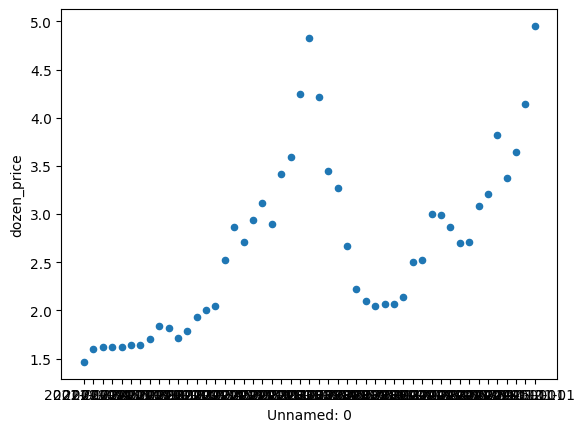

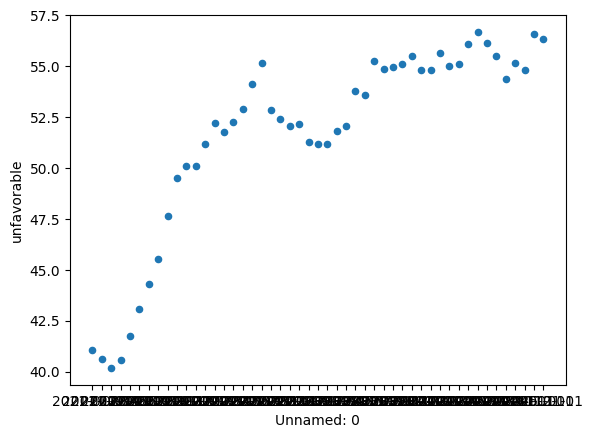

In [18]:
data_full.plot.scatter(x='Unnamed: 0', y='dozen_price') # egg prices v. time
data_full.plot.scatter(x='Unnamed: 0', y='unfavorable') # disapproval v. time

The sweet spot between packed correlations and positive trends looks to be the inflation rate, but even then, the trend isn't one-dimensional: it looks to be quadratic, indicating that both very low and extremely high inflation rates improve Biden's approval rating(???). I don't buy that those edge cases are an accurate indicator of the nation's opinion of Biden due to inflation, but his disapproval rating being higher during relative periods of high inflation (as the rest of the graph shows) makes sense, given that unemployment has little to no impact on the nation's idea of how "healthy" the economy is, as well as the impact on the disapproval rating that the model found from egg prices.

Gas prices and the amount of fentanyl seized seem to have the lowest effect on Biden's approval rating and the relationship doesn't seem to change much over time. As such, the variation on how much they impact the approval rating is relatively low. The fact that gas prices don't have a huge impact on the approval rating according to the ICE plot, given the earlier graph and all of the research that I had read over the past several years, was pretty surprising to me. Fentanyl not having much of an impact, on the other hand, did not surprise me that much--I thought that it would have the lowest impact from the start, and the model did not do much to change my priors.

Let's see the variable importance/$R^2$ chart:

<Axes: ylabel='R²'>

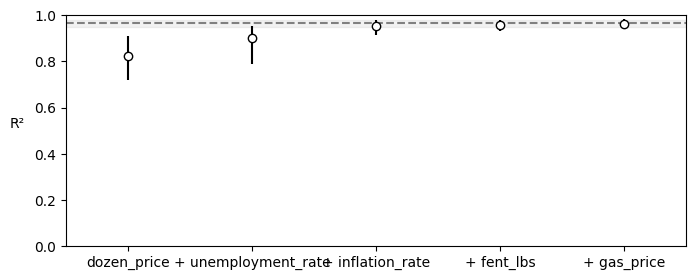

In [ ]:
vi_all = pmb.compute_variable_importance(idata_unfav_all, μ_, X)
pmb.plot_variable_importance(vi_all)

It seems as though the price of eggs and the unemployment rate alone do a pretty god job of estimating Biden's disapproval rating, which sounds weird at first (why egg prices and not gas or overall inflation?), but it does make some sense: if we view the unemployment rate as "time elapsed since the beginning of the presidency" instead of the unemployment rate (I outlined earlier why it's useful to think of it that way), it assumes that the biggest impact on Biden's disapproval rating is the price of eggs, perhaps the most commonly purchased items on a week-to-week basis, and if we adjust for the "honeymoon effect" (time), we can get a pretty good idea of what people think about the economy (and the President) as a result. Inflation rate seems to help out the model a little bit more, which makes sense, as it would contextualize the price of eggs in the context of the entire inflationary environment, which fluctuates much less than eggs do.